# Combustion analysis in a coal-fired power plant

In [101]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
from scipy.signal import find_peaks, findfreqs

In [163]:
DATA_FILE = "a08r.mat"
ARRAY_NAME = "a08r"
SPS = 8192 # Samples per second

### findMaximum
Funkcja służąca do wyszukiwanie punktów maksimum w otrzymanych danych

Parametry:
- data: dataFrame z danymi, cały niezmodyfikowany
- column: nazwa kolumny w której chcemy szukać
- width: minimalna szerokość (x) piku
- distance: minimlna odległość (x) pomiędzy szukanymi punktami
- threshold: minimlna/maksymalna odległość (y) pomiędzy szukanymi punktami
- prominence: eeee, to nie wiem, ale czasami jak większe to pomaga eliminować podwójne punkty
  
Zwraca listę z punktami maksimum


In [203]:
def findMaximums(data: pd.DataFrame, column: str, width: int, distance: int, threshold: list, prominence: float) -> list:
    """Funkcja służąca do wyszukiwanie punktów maksimum w otrzymanych danych

    Args:
        data (pd.DataFrame): dataFrame z danymi, cały niezmodyfikowany
        column (str): nazwa kolumny w której chcemy szukać
        width (int): minimalna szerokość (x) piku
        distance (int): minimlna odległość (x) pomiędzy szukanymi punktami
        threshold (list): minimlna/maksymalna odległość (y) pomiędzy szukanymi punktami
        prominence (float): eeee, to nie wiem, ale czasami jak większe to pomaga eliminować podwójne punkty

    Returns:
        list: Zwraca listę z punktami maksimum
    """
    ret = []
    ret = find_peaks(data[column], width=width, distance=distance, threshold=threshold, prominence=prominence)[0].tolist()
    return ret   

        ch1       ch2       ch3       ch4       ch5
0  0.049816  0.179095  0.170236  0.177783  0.679478
1  0.048832  0.177783  0.170236  0.177455  0.679150
2  0.049488  0.178111  0.170236  0.177455  0.678165
2457600


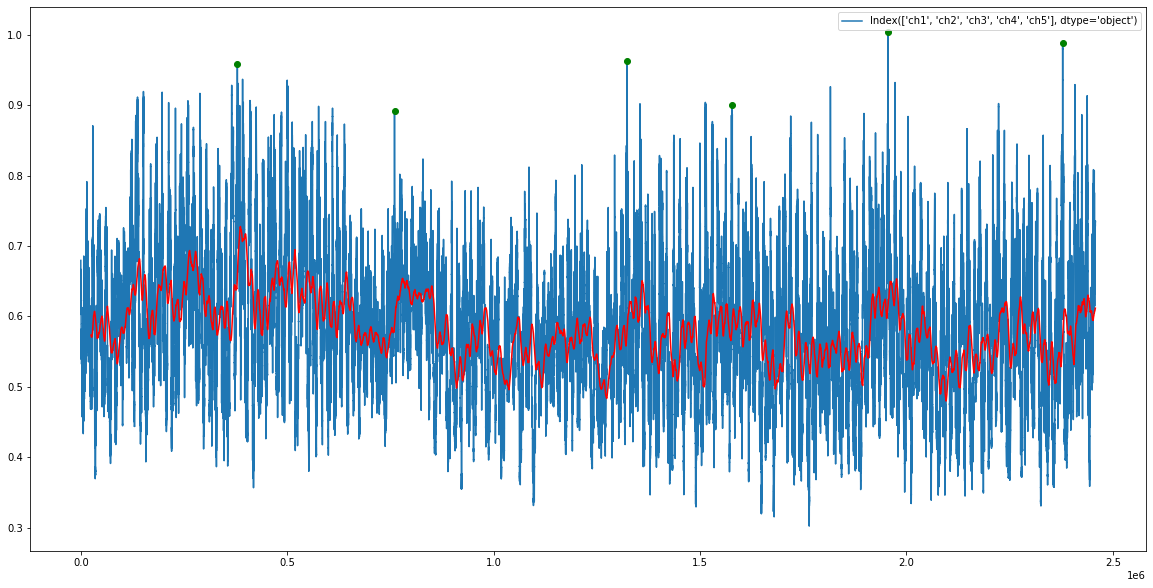

In [226]:
if __name__ == "__main__":
    
    data = pd.DataFrame(loadmat(DATA_FILE)[ARRAY_NAME], columns=(["ch1", "ch2", "ch3", "ch4", "ch5"]))
    print(data.head(3))
    print(data["ch1"].size)  
    
    min = findMaximums(data, "ch5", 10, SPS*30, None, 0.4)
    plt.figure(figsize=(20, 10))
    plt.plot(data["ch5"], label=data.columns)
    plt.plot(data["ch5"].rolling(SPS*3).mean(), color="r")
    
    y_plot = []
    
    for item in min:
        y_plot.append(data["ch5"][item])
    
    plt.plot(min, y_plot, "o", color="g")
    plt.legend()
    plt.show()
    